06_hyperparameter_tuning

In [43]:
df8.head()

,PC1,PC2,PC5,PC6,PC7,PC9,PC10,PC11,target,kmeans_cluster,mapped_cluster,hierarchical_cluster
0,-0.934705,0.208983,0.295308,0.854774,0.460738,-0.720801,0.068016,-0.473150,1,1,0,0
1,1.178217,-0.474548,-2.503069,1.252529,-0.727266,0.304813,0.452006,-0.147921,1,0,1,1
2,1.795845,-0.335914,-0.614711,0.369755,-0.640217,-0.775945,-0.507854,-0.183852,1,0,1,1
3,1.487897,0.275915,0.117819,1.056054,0.420623,-0.031369,-0.776480,-0.262647,1,0,1,1
4,0.642607,1.615479,-0.470656,0.328765,-0.041536,0.177160,-0.447931,0.932342,1,2,1,1


In [44]:
%store -r df_pca
%store -r df
%store -r df8

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.stats import randint
import numpy as np

HyperTuning Random forests

In [46]:
X=df8.drop(columns=['target', 'hierarchical_cluster', 'mapped_cluster','kmeans_cluster' ], axis=1)
y=df8['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)



In [47]:
param_dist = {
    'n_estimators': randint(100, 300),            # number of trees
    'max_depth': [None, 10, 20, 30, 40, 50],       # max tree depth
    'min_samples_split': [2, 5, 10],              # minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],                # min samples at a leaf
    'max_features': ['auto', 'sqrt', 'log2'],     # features to consider at split
    'bootstrap': [True, False]                    # use bootstrap samples?
}

In [48]:
rf=RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                 # number of random combinations to try
    cv=5,                      # 5-fold cross-validation
    scoring='accuracy',        # or use 'f1', 'roc_auc', etc.
    verbose=2,
    random_state=42,
    n_jobs=-1                  # use all CPU cores
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Zeyad Elsawi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
105 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
29 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Zeyad Elsawi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Zeyad Elsawi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Zeyad Elsawi\AppData\Local\Programs\Python\Python312\Lib

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022D6A157D70>},
                   random_state=42, scoring='accuracy', verbose=2)

In [49]:
print("Best parameters:", random_search.best_params_)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best parameters: {'bootstrap': True, 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 264}
Accuracy: 0.7868852459016393
Confusion Matrix:
 [[20  8]
 [ 5 28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.71      0.75        28
           1       0.78      0.85      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



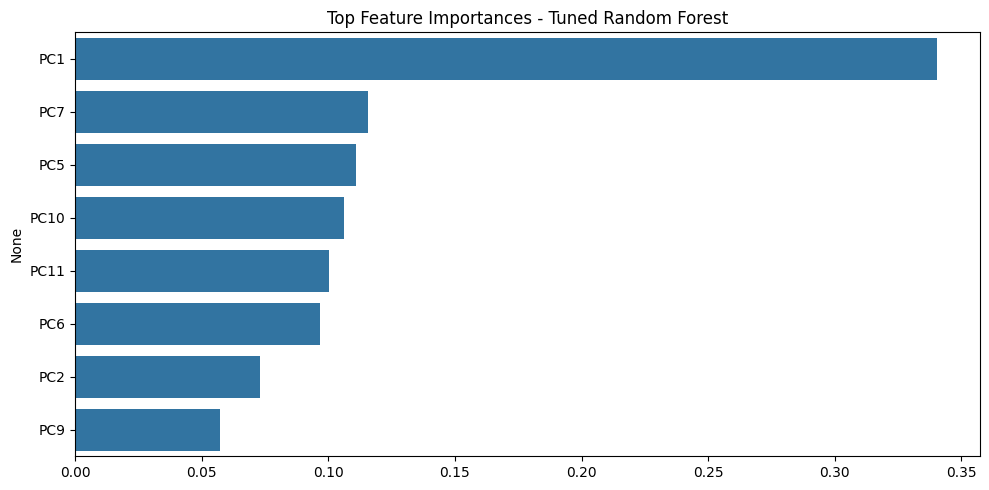

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns[indices]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[indices], y=features)
plt.title("Top Feature Importances - Tuned Random Forest")
plt.tight_layout()
plt.show()


SVC

In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],             # Regularization
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],         # Kernel coefficient
    'degree': [2, 3, 4]                 # Only used for 'poly' kernel
}

svm = SVC(probability=True)  # Needed for ROC curve
grid_svm = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_svm.fit(X_train, y_train)

print("Best SVM Params:", grid_svm.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best SVM Params: {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


In [52]:
svc=SVC(kernel='rbf', C=1, gamma='scale' ,degree=2)
svc.fit(X_train, y_train)
y_pred=svc.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.82      0.64      0.72        28
           1       0.74      0.88      0.81        33

    accuracy                           0.77        61
   macro avg       0.78      0.76      0.76        61
weighted avg       0.78      0.77      0.77        61

0.7704918032786885
[[18 10]
 [ 4 29]]


Logistic Regression 


In [53]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],       # Inverse of regularization
    'penalty': ['l1', 'l2'],            # Type of regularization
    'solver': ['liblinear', 'saga']     # Solvers supporting L1
}

logreg = LogisticRegression(max_iter=1000)
grid_log = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_log.fit(X_train, y_train)

print("Best Logistic Regression Params:", grid_log.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Logistic Regression Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [54]:
logreg=LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))




              precision    recall  f1-score   support

           0       0.84      0.75      0.79        28
           1       0.81      0.88      0.84        33

    accuracy                           0.82        61
   macro avg       0.82      0.81      0.82        61
weighted avg       0.82      0.82      0.82        61

0.819672131147541
[[21  7]
 [ 4 29]]


Decision Trees

In [55]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

tree = DecisionTreeClassifier()
grid_tree = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_tree.fit(X_train, y_train)

print("Best Decision Tree Params:", grid_tree.best_params_)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [56]:
tree=DecisionTreeClassifier(max_depth=20, min_samples_split=5, min_samples_leaf=2, criterion='entropy')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))




              precision    recall  f1-score   support

           0       0.63      0.68      0.66        28
           1       0.71      0.67      0.69        33

    accuracy                           0.67        61
   macro avg       0.67      0.67      0.67        61
weighted avg       0.67      0.67      0.67        61

0.6721311475409836
[[19  9]
 [11 22]]


KNeighbors Classifier

In [57]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_knn.fit(X_train, y_train)

print("Best KNN Params:", grid_knn.best_params_)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best KNN Params: {'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'uniform'}


In [58]:
knn=KNeighborsClassifier(n_neighbors=30, weights='uniform', metric='manhattan')
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.81      0.75      0.78        28
           1       0.80      0.85      0.82        33

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61

0.8032786885245902
[[21  7]
 [ 5 28]]


Model Export & Deployment

In [59]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('scaler', StandardScaler()),
    # optionally: ('pca', PCA(n_components=5)),
    ('model', logreg)
])

pipe.fit(X_train, y_train)
joblib.dump(pipe, 'heart_disease_model.pkl')


['heart_disease_model.pkl']

In [60]:
loaded_model = joblib.load('heart_disease_model.pkl')
y_pred = loaded_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))






              precision    recall  f1-score   support

           0       0.83      0.71      0.77        28
           1       0.78      0.88      0.83        33

    accuracy                           0.80        61
   macro avg       0.81      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61

0.8032786885245902
[[20  8]
 [ 4 29]]


In [63]:
print(df.columns.tolist())

['age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'ca', 'target', 'cp_1', 'cp_2', 'cp_3', 'thal_1', 'thal_2', 'thal_3', 'slope_1', 'slope_2']


In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

# Load your full encoded DataFrame
# This must contain raw input features
df1=pd.read_csv('../Data/heart-disease-data.csv')
Xx = df1.drop("target", axis=1)
yy = df1["target"]

# Define feature types
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# 1. ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(), categorical_cols)
])

# 2. PCA and RFE are not directly compatible with pipeline
# So we wrap RFE as a custom transformer
class RFETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rfe_model):
        self.rfe_model = rfe_model
    def fit(self, Xx, yy=None):
        return self
    def transform(self, Xx):
        return self.rfe_model.transform(X)

# 3. Fit preprocessing
Xx_preprocessed = preprocessor.fit_transform(Xx)

# 4. Apply PCA
pca = PCA(n_components=12)
Xx_pca = pca.fit_transform(Xx_preprocessed)

# 5. Apply RFE
rfe = RFE(LogisticRegression(), n_features_to_select=8)
X_selected = rfe.fit_transform(Xx_pca, y)

# 6. Fit final model
final_model = LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
final_model.fit(X_selected, y)

# 7. Full pipeline (raw input → prediction)
full_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', pca),
    ('rfe', RFETransformer(rfe)),
    ('logreg', final_model)
])

# 8. Save pipeline
joblib.dump(full_pipeline, 'heart_disease_model.pkl')


['heart_disease_model.pkl']